In [1]:
# Importações
import pandas as pd
import matplotlib as ml
import numpy as np
import math as mt
import pprint
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
pp = pprint.PrettyPrinter(width=1000, compact=True)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)

In [2]:
#Leitura dos dados
colunas=pd.read_csv("C:/Users/Roger/OneDrive/ESPECIAL/IA006/python/har_smartphone/features.txt",delim_whitespace=True,header=None)
colunas=colunas[0].astype(str)+"-"+colunas[1]
colunas=colunas.values.tolist()
x_treino_df=pd.read_csv("C:/Users/Roger/OneDrive/ESPECIAL/IA006/python/har_smartphone/X_train.txt",names=colunas,delim_whitespace=True)
x_teste_df=pd.read_csv("C:/Users/Roger/OneDrive/ESPECIAL/IA006/python/har_smartphone/X_test.txt",names=colunas,delim_whitespace=True)
y_treino_df=pd.read_csv("C:/Users/Roger/OneDrive/ESPECIAL/IA006/python/har_smartphone/y_train.txt",names=['Label'],delim_whitespace=True)
y_teste_df=pd.read_csv("C:/Users/Roger/OneDrive/ESPECIAL/IA006/python/har_smartphone/y_test.txt",names=['Label'],delim_whitespace=True)

[[<matplotlib.axes._subplots.AxesSubplot object at 0x05BA8370>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x05BCFD10>]]


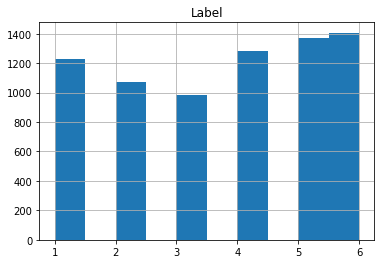

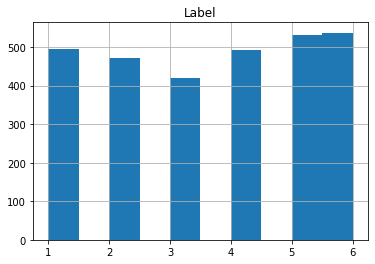

In [19]:
#Apesar de ter nomes duplicados nas colunas os valores são diferentes(não verifiquei para todas as opções, talvez o nome devese ser igual mesmo verifficar documentação)
# print(x_treino_df['339-fBodyAcc-bandsEnergy()-1,16'])
# print(x_treino_df['325-fBodyAcc-bandsEnergy()-1,16'])
print(y_treino_df.hist())
print(y_teste_df.hist())

In [119]:
#Não há linhas com nan
# print(x_treino_df[x_treino_df.isnull().any(axis=1)])
# print(y_treino_df[y_treino_df.isnull().any(axis=1)])
# print(x_teste_df[x_teste_df.isnull().any(axis=1)])
# print(y_teste_df[y_teste_df.isnull().any(axis=1)])

In [121]:
# #As classes estão mais ou menos igualmente distribuidas.
# y_treino_df.hist()
# plt.show()
# y_teste_df.hist()
# plt.show()

In [50]:
#Não funciona muito lento
# def getDuplicateColumns(df):
#     '''
#     Get a list of duplicate columns.
#     It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
#     :param df: Dataframe object
#     :return: List of columns whose contents are duplicates.
#     '''
#     duplicateColumnNames = set()
#     # Iterate over all the columns in dataframe
#     for x in range(df.shape[1]):
#         # Select column at xth index.
#         col = df.iloc[:, x]
#         # Iterate over all the columns in DataFrame from (x+1)th index till end
#         for y in range(x + 1, df.shape[1]):
#             # Select column at yth index.
#             otherCol = df.iloc[:, y]
#             # Check if two columns at x 7 y index are equal
#             if col.equals(otherCol):
#                 duplicateColumnNames.add(df.columns.values[y])
 
#     return list(duplicateColumnNames)

In [10]:
#Standarlizando os dados
def dataframe_stand(x):
  return (x-x.mean(axis=0))/x.std(axis=0)

x_treino_df_stand=dataframe_stand(x_treino_df).copy()
x_teste_df_stand=dataframe_stand(x_teste_df).copy()

#Adicionando a coluna com "1"
x_treino_df_stand['C']=1
x_teste_df_stand['C']=1


In [16]:
#Funções Diversas
#calculo da estimativa
def yh_func(x,w):
#     print(np.exp(np.dot(x,w)).shape)
    z=np.sum(np.exp(np.dot(x,w)),axis=1)
    yh=np.exp(np.dot(x,w))/z
    print(yh.shape)
    return yh


#calculo do gradiente
def grad_func(y,yh,x):
    grad=np.dot(np.transpose(y-yh),x)/len(x)
    return grad

#calculo do treshold
def threshold_func(y,t):
    z=y.copy()
    for k in range(0,len(z)):
        if z[k]>t:
            z[k]=1
        if z[k]<=t:
            z[k]=0
    return z


#Função para o gradiente descendente
def logistic_train_func(w_antigo,x,y,max_iteracoes,precisao_parada,passo):
#     w é um vetor inicial
    custo_lista=[]
    yh_antigo=yh_func(x,w_antigo)
    custo_antigo=log_loss(y,yh_antigo)
    custo_lista.append(custo_antigo)
    for i in range(1,max_iteracoes+1):
        w_novo=w_antigo-passo*grad_func(y,yh_antigo,x) 
        yh_novo=yh_func(x,w_novo)
        custo_novo=log_loss(y,yh_novo)
        custo_lista.append(custo_novo)
        if abs(custo_novo-custo_antigo)<precisao_parada:
            mensagem="Parado por precisão."
            break;
        if i==max_iteracoes:
            mensagem="Parado por número de Iterações."
            break;
        custo_antigo=custo_novo
        yh_antigo=yh_novo
        w_antigo=w_novo
    return custo_lista,w_novo,custo_novo,abs(custo_antigo-custo_novo),i,mensagem


In [7]:
#retorna vetor 1 ou 0 de varias labels
def labelizer_func(y,classe):
    y_l=y.copy()
    for k in range(0,len(y_l)):
        if y_l[k]==classe:
            y_l[k]=1
        else:
            y_l[k]=0
    return y_l



In [20]:
y_treino_l=np.zeros([len(y_treino_df.values[:,0]),6])
print(y_treino_l.shape)
for classe in range(1,7):
    y_treino_l[:,classe-1]=np.transpose(labelizer_func(y_treino_df.values[:,0],classe))

#Agora meu y_treino_l esta labelizado

max_it=2500
pp=0.000000001
passo=0.03
w_inicial=np.zeros([562,6])
w_final=np.empty([562,6])
# grafico_custo,w_final,custo_final,precisao,i,mensagem=logistic_train_func(w_inicial[:,classe-1],x_treino_df_stand.values,y_treino_l,max_it,pp,passo)
x=np.array([[1,2],[1,4],[1,5],[1,6]])
w=np.array()
print(np.exp(np.dot(x,w))/np.sum(np.exp(np.dot(x,w)),axis=1))


(7352, 6)
(7352, 6)


ValueError: operands could not be broadcast together with shapes (7352,6) (7352,) 

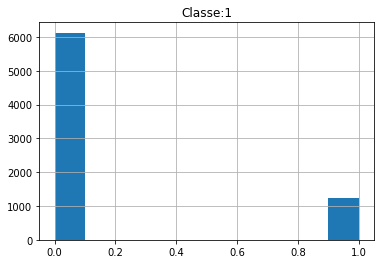

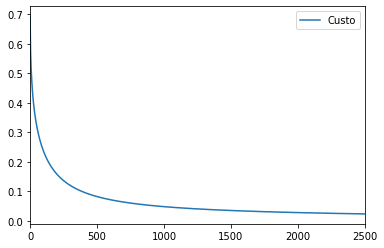

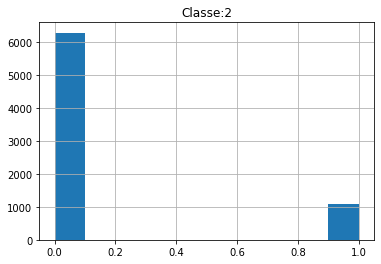

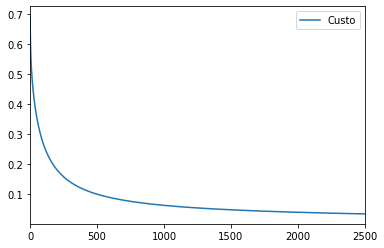

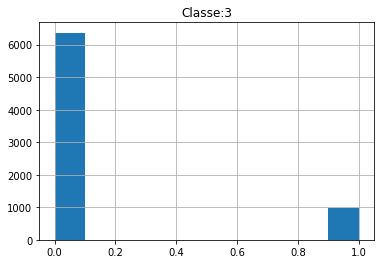

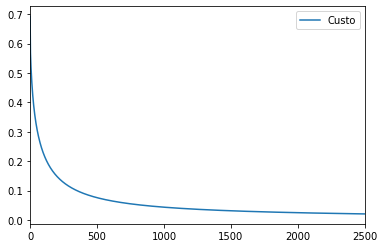

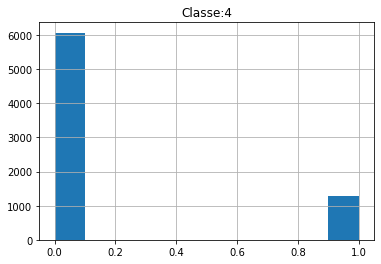

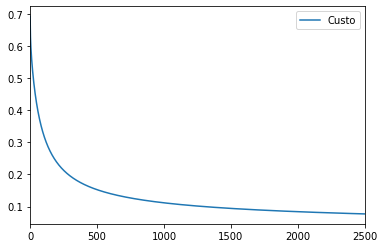

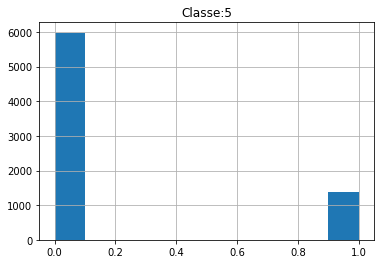

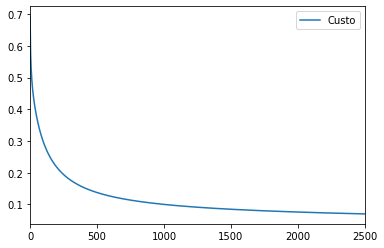

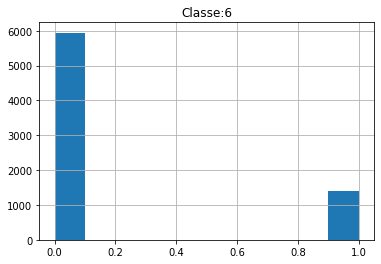

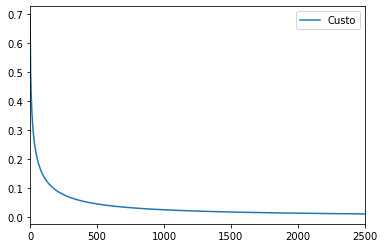

Tempo rodada:167.70004725456238 s


In [24]:
import time
max_it=2500
pp=0.000000001
passo=0.03
w_inicial=np.zeros([562,6])
w_final=np.empty([562,6])
start=time.time()
for classe in range(1,7):
#     Transforma o vetor de classe em um vetor de 0 e 1
    y_treino_l=labelizer_func(y_treino_df.values[:,0],classe)

    #Gráfico historgrama após labelizacao
    titulo="Classe:{}".format(classe)
    pd.DataFrame(y_treino_l,columns=[titulo]).hist()

    #treino do modelo
    grafico_custo,w_final[:,classe-1],custo_final,precisao,i,mensagem=logistic_train_func(w_inicial[:,classe-1],x_treino_df_stand.values,y_treino_l,max_it,pp,passo)

    #grafico do custo
    grafico_custo=pd.DataFrame(grafico_custo,columns=['Custo'])
    plt.title(titulo)
    grafico_custo.plot()
#     plt.show()
# print(grafico_custo)
plt.show()
print("Tempo rodada:{} s".format(time.time()-start))

In [15]:
yh_teste=yh_func(x_teste_df_stand.values,w_final)
# print(x_treino_df_stand.shape)
# print(w_final.shape)
# print(yh_treino.shape)
# teste=pd.DataFrame(yh_treino,columns=['Classe1'])
# teste['Real']=y_treino_df
# teste[teste['Real']==classe]
yh_teste_l=np.zeros(yh_teste.shape[0])
for i in range(0,yh_teste.shape[0]):
    yh_teste_l[i]=np.where(yh_teste[i,:] == np.amax(yh_teste[i,:]))[0]+1
# print(yh_teste2)
# print(y_teste_df.values[:,0])
print(confusion_matrix(y_teste_df.values[:,0], yh_teste_l, labels=[1,2,3,4,5,6]))
# confirmacao=pd.DataFrame(yh_teste,columns=[1,2,3,4,5,6])
# confirmacao['Estimado']=yh_teste2
# confirmacao['Verdadeiro']=y_teste_df['Label']
# confirmacao.to_csv(r'C:/Users/Roger/OneDrive/ESPECIAL/IA006/python/har_smartphone/resultados.csv')
# print(confirmacao)

[[483   6   7   0   0   0]
 [  6 459   6   0   0   0]
 [  2   4 414   0   0   0]
 [  0   1   0 435  55   0]
 [  0   0   0  29 503   0]
 [  0   0   0   0   0 537]]


[[483   6   7   0   0   0]
 [  6 459   6   0   0   0]
 [  2   4 414   0   0   0]
 [  0   1   0 435  55   0]
 [  0   0   0  29 503   0]
 [  0   0   0   0   0 537]]


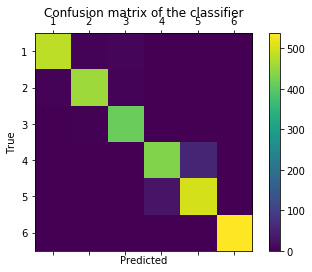

              precision    recall  f1-score   support

           1      0.984     0.974     0.979       496
           2      0.977     0.975     0.976       471
           3      0.970     0.986     0.978       420
           4      0.938     0.886     0.911       491
           5      0.901     0.945     0.923       532
           6      1.000     1.000     1.000       537

    accuracy                          0.961      2947
   macro avg      0.961     0.961     0.961      2947
weighted avg      0.961     0.961     0.961      2947



In [25]:
labels = [1,2,3,4,5,6]
cm = confusion_matrix(y_teste_df.values[:,0], yh_teste_l, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_teste_df.values[:,0], yh_teste_l,digits=3))

In [18]:
print(confusion_matrix([1,1,2,2,3,3],[1,1,1,1,1,1],[1,2,3]))
# print(confusion_matrix([1,1,2,2,3,3],[[1,1,1,1,1,1],[1,1,1,1,1,1],[1,1,1,1,1,1]],[1,2,3]))

[[2 0 0]
 [2 0 0]
 [2 0 0]]


In [9]:
def division_zero(a, b):
    if b:
        x=a/b
    if b==0:
        x=0
    return x

lis_treshold=np.arange(0,1+step,step)
f_medida_lista=[]
for t in lis_treshold:
    yh_teste_t=threshold_func(yh_teste,t)
    tn, fp, fn, tp=confusion_matrix(y_teste, yh_teste_t).ravel()
    recall=division_zero(tp,(tp+fn))
    precisao=division_zero(tp,fp+tp)
    a=recall*precisao
    b=recall+precisao
    f_medida=division_zero(a,b)
    f_medida_lista.append([t, f_medida])

#Gráfico 1
grafico_f_medida=pd.DataFrame(f_medida_lista,columns=['t','F_medida'])
grafico_f_medida.plot(x='t',y='F_medida')
plt.show()

#Gráfico 2
x=np.array(f_medida_lista)
x=x[:,0].copy()
y=np.array(f_medida_lista)
y=y[:,1].copy()
plt.plot(x,y,'.--')
plt.show()

NameError: name 'step' is not defined

In [3]:


import sklearn as sk
from sklearn.linear_model import LogisticRegression
import pandas as pd

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(x_treino, y_treino)
yh_treino=LR.predict(x_treino)
yh_teste=LR.predict(x_teste)
print("treino")
print("tn, fp, fn, tp")
print(confusion_matrix(y_treino, yh_treino).ravel()/len(y_treino)*100)
print("teste")
print("tn, fp, fn, tp")
print(confusion_matrix(y_teste,yh_teste).ravel()/len(y_teste)*100)


def custo_func(y,yh):
#     custo=-np.sum(y_treino*np.log(yh_treino)+(1-y_treino)*np.log(1-yh_treino))/len(y)
#     return custo
    eps=1e-15
    custo=-
    yh = np.clip(yh, eps, 1 - eps)
    for i in range(0,len(y)):
        if y[i] == 1:
            custo+= -np.log(yh[i])
        else:
            custo+= -np.log(1 - yh[i])
    custo=custo/len(y)
    return custo


# teste
# import numpy as np
# from sklearn.model_selection import KFold

# X = np.array(["a", "b", "c", "d","e","f","g","h"])
# kf = KFold(n_splits=5)
# for train_index, test_index in kf.split(X):
#     print(train_index)
#     print(X[train_index])
#     print(test_index)
#     print(X[test_index])

# h=np.array([0,1,2])
# print(X[h])

#teste
# print(log_loss([1,0],[1,1]))
# print(1*np.log(1))

# algoritmo para logloss
def logloss(true_label, predicted, eps=1e-15):
  p = np.clip(predicted, eps, 1 - eps)
  print(p)
  if true_label == 1:
    return -np.log(p)
  else:
    return -np.log(1 - p)

#códigos legais
# print(x_treino.shape)
# print(w.shape[0])
# print(w.shape)
# print(len(w))



y_true = [0, 0, 1, 1]
y_pred = [0.0,0.9,0.1,0.7]
teste=0
for i in range(0,len(y_true)):
    teste+=logloss(y_true[i],y_pred[i])

teste=teste/len(y_true)
print(teste)
print(log_loss(y_true,y_pred))
np.log(0.000000000000000000000000000000000000001)

1e-15
0.9
0.1
0.7
1.240461282481706
1.240461282481706


-89.80081862676778

In [68]:
# ar1=np.array([1,2,2,3])
# ar2=np.array([[1,0,0,0],[0,1,1,0],[0,0,0,1]])
# print(log_loss(ar1,ar2))

actual_labels = [1,2,3]

log_loss(actual_labels,  [[1, 0, 0], [0, 1, 0], [0, 0, 1]])

0.1351550360360566

In [64]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit([1, 2, 6, 6, 2])
print(lb.classes_)
print(lb.transform([1, 6]))

[1 2 6]
[[1 0 0]
 [0 0 1]]


In [27]:
arr = np.array([11, 12, 13, 14, 15, 16, 17, 15, 11, 12, 14, 15, 16, 17])
result = np.where(arr == np.amax(arr))
print(result[0])

[ 6 13]


In [54]:
confusion_matrix([1,1,2,2,3,3],[1,2,2,2,5,3], labels=[1,2,3])

array([[1, 1, 0],
       [0, 2, 0],
       [0, 0, 1]], dtype=int64)